# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [ ]:
!nvidia-smi

Wed Dec 14 06:47:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 174 kB 35.9 MB/s 
     |████████████████████████████████| 2.2 MB 77.2 MB/s 
     |████████████████████████████████| 168 kB 87.5 MB/s 
     |████████████████████████████████| 182 kB 69.8 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 87.0 MB/s 
     |████████████████████████████████| 166 kB 92.1 MB/s 
     |████████████████████████████████| 166 kB 88.6 MB/s 
     |████████████████████████████████| 162 kB 80.4 MB/s 
     |████████████████████████████████| 162 kB 88.4 MB/s 
     |████████████████████████████████| 158 kB 91.7 MB/s 
     |████████████████████████████████| 157 kB 75.9 MB/s 
     |████████████████████████████████| 157 kB 92.0 MB/s 
     |████████████████████████████████| 157 kB 91.2 MB/s 
     |████████████████████████████████| 157 kB 91.9 MB/s 
     |████████████████████████████████| 157 kB 90.7 MB/s 
     |███████████

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# TODO: Import drive if you are a colab user
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 64,
    'epochs': 100,
    'lr': 0.00008235
}

# Toy Data Setup

The toy dataset is very essential for you in this HW. The model which you will be building is complicated and you first need to make sure that it runs on the toy dataset. <br>
In other words, you need convergence - the attention diagonal. Take a look at the write-up for this. <br>
We have given you the following code to download the toy data and load it. You can use it the way it is. But be careful, the transcripts are different from the original data from kaggle. The toy dataset has phonemes but the actual data has characters.

In [ ]:
!wget -q https://cmu.box.com/shared/static/wok08c2z2dp4clufhy79c5ee6jx3pyj9 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/zctr6mvh7npfn01forli8n45duhp2g85 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/m2oaek69145ljeu6srtbbb7k0ip6yfup --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/owrjy0tqra3v7zq2ru7mocy2djskydy9 --content-disposition --show-progress

f0176_mfccs_train.n 100%[===================>] 279.30M  12.5MB/s    in 26s     
f0176_mfccs_dev.npy 100%[===================>]  27.93M  18.6MB/s    in 1.5s    
f0176_hw3p2_train.n 100%[===================>]   7.02M  23.0MB/s    in 0.3s    
f0176_hw3p2_dev.npy 100%[===================>] 718.88K  3.43MB/s    in 0.2s    


In [ ]:
# Load the toy dataset
X_train = np.load("f0176_mfccs_train.npy")
X_valid = np.load("f0176_mfccs_dev.npy")
Y_train = np.load("f0176_hw3p2_train.npy")
Y_valid = np.load("f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP["[PAD]"]  = len(VOCAB_MAP)
VOCAB               = list(VOCAB_MAP.keys())

SOS_TOKEN = VOCAB_MAP["[SOS]"]
EOS_TOKEN = VOCAB_MAP["[EOS]"]
PAD_TOKEN = VOCAB_MAP["[PAD]"]

Y_train = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_valid]

In [ ]:
# Dataset class for the Toy dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train[:, :, :15]
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid[:, :, :15]
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

# Kaggle Data

In [ ]:
# TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ramanathan16","key":"d4035f55a52974a7c4d6bae8054bc215"}')

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 3.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73274 sha256=bdf773287b2543e1371ed27f4f87a6d4081eaa622d3d09a554af678898382eab
  Stored in directory: /root/.cache/pip/wheels/f3/67/7b/a6d668747974998471d29b230e7221dd01330ac34faebe4af4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

 99% 2.06G/2.09G [00:11<00:00, 231MB/s]
100% 2.09G/2.09G [00:11<00:00, 201MB/s]


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
from numpy.core.fromnumeric import partition
# TODO: Create a dataset class which is exactly the same as HW3P2. You are free to reuse it. 
# The only change is that the transcript mapping is different for this HW.
# Note: We also want to retain SOS and EOS tokens in the transcript this time.
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, partition='train-clean-100', context=0, offset=0): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them
        self.mfcc_dir = 'data/hw4p2/'+partition+'/mfcc'
        self.transcript_dir = 'data/hw4p2/'+partition+'/transcript/raw'

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.VOCAB_MAP = VOCAB_MAP

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?

        self.mfccs, self.transcripts = [], []

        for i in range(0, len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(self.mfcc_dir+"/"+self.mfcc_files[i])
        #   Optionally do Cepstral Normalization of mfcc
            mfcc = (mfcc - np.mean(mfcc, axis=0))/np.std(mfcc, axis=0)
        #   Load the corresponding transcript
            transcript = np.load(self.transcript_dir+"/"+self.transcript_files[i])
            # without traversing through the transcript?)
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

        self.length = len(self.mfccs)
        t = []
        for tr in self.transcripts:
          t.append(np.array([self.VOCAB_MAP[i] for i in tr]))
        self.transcripts = t

        
        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        
        frames = self.mfccs[ind] 
        frames = torch.FloatTensor(frames) # Convert to tensors

        phoneme = torch.tensor(self.transcripts[ind])       

        return frames, phoneme


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [b[0] for b in batch] # TODO
        # batch of output phonemes
        batch_transcript = [b[1] for b in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=0.0) # TODO
        lengths_mfcc = [len(m) for m in batch_mfcc] # TODO 


        #time_mask = min(lengths_mfcc)//4
        if partition == 'train-clean-100':
          batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=0.0) # TODO
          lengths_mfcc = [len(m) for m in batch_mfcc] # TODO
          t_mask = torchaudio.transforms.TimeMasking(time_mask_param=11)
          f_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=6)
          batch_mfcc_pad = t_mask(torch.permute(batch_mfcc_pad, (0,2,1)))
          batch_mfcc_pad = torch.permute(batch_mfcc_pad, (0,2,1))
          batch_mfcc_pad = f_mask(batch_mfcc_pad)

          batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, batch_first=True, padding_value=0.0) # TODO
          lengths_transcript = [len(t) for t in batch_transcript] # TODO

        else:

          batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=EOS_TOKEN) # TODO
          lengths_mfcc = [len(m) for m in batch_mfcc] # TODO 

          batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, batch_first=True, padding_value=EOS_TOKEN) # TODO
          lengths_transcript = [len(t) for t in batch_transcript] # TODO


        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
# TODO: Similarly, create a test dataset class
class AudioDatasetTest(torch.utils.data.Dataset):
   def __init__(self, partition='test-clean'): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        # Load the directory and all files in them

        self.mfcc_dir = 'data/hw4p2/'+partition+'/mfcc'

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.VOCAB_MAP = VOCAB_MAP

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)

        self.mfccs, self.transcripts = [], []

        for i in range(0, len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(self.mfcc_dir+"/"+self.mfcc_files[i])
        #   Optionally do Cepstral Normalization of mfcc
            mfcc = (mfcc - np.mean(mfcc, axis=0))/np.std(mfcc, axis=0)
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
        
        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        self.length = len(self.mfccs)

   def __len__(self):
    return self.length

   def __getitem__(self, ind):
        
        frames = self.mfccs[ind] 
        frames = torch.FloatTensor(frames) # Convert to tensors     
        return frames

   def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [b for b in batch] # TODO
        # batch of output phonemes
       

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, batch_first=True, padding_value=0.0) # TODO
        lengths_mfcc = [len(m) for m in batch_mfcc] # TODO 


        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

# Dataset and Dataloaders

In [ ]:
# TODO: Create the datasets and dataloaders
# All these things are similar to HW3P2
# You can reuse the same code

# Create objects for the dataset class
train_data = AudioDataset() #TODO
val_data = AudioDataset(partition='dev-clean') # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest() #TODO

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(train_data, num_workers= 4,
                                           batch_size=config['batch_size'], pin_memory= True,
                                           shuffle= True, collate_fn=train_data.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, num_workers= 2,
                                         batch_size=config['batch_size'], pin_memory= True,
                                         shuffle= False, collate_fn=val_data.collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, 
                                          batch_size=config['batch_size'], pin_memory= True, 
                                          shuffle= False, collate_fn=test_data.collate_fn)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  64
Train dataset samples = 28539, batches = 446
Val dataset samples = 2703, batches = 43
Test dataset samples = 2620, batches = 41


In [ ]:
# The sanity check for shapes also are similar
# Please remember that the only change in the dataset for this HW is the transcripts
# So you are expected to get similar shapes like HW3P2 (Pad, pack and Oh my!)
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x)
    print(x.shape, y.shape, lx.shape, ly.shape)
    break 

tensor([[[-1.0012, -0.9292,  1.0250,  ...,  0.2972,  1.1876,  0.4296],
         [-0.9962, -1.0627,  0.9343,  ..., -0.0403,  1.2771,  0.8226],
         [-1.0343, -1.2558,  0.7986,  ..., -0.1392,  1.3981,  1.1671],
         ...,
         [29.0000, 29.0000, 29.0000,  ..., 29.0000, 29.0000, 29.0000],
         [29.0000, 29.0000, 29.0000,  ..., 29.0000, 29.0000, 29.0000],
         [29.0000, 29.0000, 29.0000,  ..., 29.0000, 29.0000, 29.0000]],

        [[-1.3219, -0.9235, -0.8587,  ...,  1.1284,  2.0676,  0.8747],
         [-1.2941, -0.8819, -0.8295,  ...,  1.1887,  1.8024,  0.9451],
         [-1.2828, -0.9699, -0.8108,  ...,  1.0224,  1.5366,  0.7280],
         ...,
         [-1.2051, -0.7688, -0.6644,  ...,  1.6119,  1.9812,  0.4407],
         [-1.2103, -0.7759, -0.6938,  ...,  1.7938,  1.9880,  0.4387],
         [-1.2552, -0.8211, -0.6201,  ...,  1.5665,  1.9931,  0.7196]],

        [[-0.6494, -0.7671, -0.1850,  ...,  0.6109,  0.6885, -0.5825],
         [-0.4636, -0.5864, -0.1526,  ...,  0

# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

### Pyramidal Bi-LSTM

In [ ]:
from torch.autograd import Variable
import sys
class LockedDropout(nn.Module):
    def forward(self, x, dropout=0.5):
        if not self.training:
          return x
        m = x.data.new(x.size(0), 1, x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, bidirectional=True, batch_first=True,) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        self.drop = LockedDropout()


    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence

        x, x_lens = torch.nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x = self.drop(x)
        x, x_lens = self.trunc_reshape(x, x_lens)
        # TODO: Pack Padded Sequence. What output(s) would you get?
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, enforce_sorted=False, batch_first=True)
        # TODO: Pass the sequence through bLSTM
        output, hidden = self.blstm(x)

        # What do you return?

        return output

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        length = (x[0].shape[0] // 2)*2
        x = x[:, :length, :]
        in_dim = x[0].shape[1]*2
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape((len(x),length//2,in_dim))
        #if x.shape[1] > x_lens:
        #  x_len = x.shape[1]
        #else:
        #  x_len= x_lens  
        #clamp
        x_len = torch.clamp(x_lens,max=x.shape[1])

        # TODO: Reduce lengths by the same downsampling factor
        return x , x_len

### Listener

In [ ]:
from re import X
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        self.conv = torch.nn.Conv1d(input_size,encoder_hidden_size,1)

        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(input_size=encoder_hidden_size, hidden_size=encoder_hidden_size, 
                          num_layers=1, bidirectional=True, batch_first=True)#TODO: Fill this up

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be? 
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # ...
            # ...
            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),
          
            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),

            pBLSTM(encoder_hidden_size*4, encoder_hidden_size),
      
        )

        self.drop = LockedDropout()
         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader

        x= x.permute(0,2,1)

        x = self.conv(x)

        x= x.permute(0,2,1)
        
        # TODO: Pack Padded Sequence
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, enforce_sorted=False, batch_first=True)
        # TODO: Pass it through the first LSTM layer (no truncation)
        packed_out,_= self.base_lstm(x)
      

        # TODO: Pad Packed Sequence
       

        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer

        encoder_outputs = self.pBLSTMs(packed_out)

        # Remember the number of output(s) each function returns

        encoder_outputs, encoder_lens = torch.nn.utils.rnn.pad_packed_sequence(encoder_outputs, batch_first=True)

        #encoder_lens = encoder_outputs.shape[1]

        return encoder_outputs, encoder_lens

In [ ]:
encoder = Listener(15,512)# TODO: Initialize Listener
print(encoder)
summary(encoder, x, lx)
del encoder

Listener(
  (conv): Conv1d(15, 512, kernel_size=(1,), stride=(1,))
  (base_lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      (drop): LockedDropout()
    )
    (1): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      (drop): LockedDropout()
    )
    (2): pBLSTM(
      (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      (drop): LockedDropout()
    )
  )
  (drop): LockedDropout()
)
                                Kernel Shape      Output Shape      Params  \
Layer                                                                        
0_conv                          [15, 512, 1]   [64, 512, 1662]      8.192k   
1_base_lstm                                -     [85337, 1024]   4.202496M   
2_pBLSTMs.0.LockedDropout_drop             -  [64, 1662, 1024]           -   
3_pBLSTMs.0.LSTM_blstm                     -     [52

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

import math

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()


        self.proj = projection_size

        self.key_projection     = torch.nn.Linear(2*encoder_hidden_size, projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(2*encoder_hidden_size, projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(decoder_output_size, projection_size)# TODO: Define an nn.Linear layer which projects the decoder_output_state to query
        # Optional : Define an nn.Linear layer which projects the context vector

        self.softmax            = torch.nn.Softmax(dim=1)# TODO: Define a softmax layer. Think about the dimension which you need to apply 
        # Tip: What is the shape of energy? And what are those?

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs)# TODO: Project encoder_outputs using key_projection to get keys
        self.value    = self.value_projection(encoder_outputs)# TODO: Project encoder_outputs using value_projection to get values

        # encoder_max_seq_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)

        # TODO: To remove the influence of padding in the raw_weights, we want to create a boolean mask of shape (batch_size, timesteps) 
        # The mask is False for all indicies before padding begins, True for all indices after.
        self.padding_mask     = (torch.arange(encoder_max_seq_len).unsqueeze(0) >= encoder_lens.unsqueeze(1)).to(DEVICE)#,value=float('-inf'))# TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        #self.padding_mask     = self.padding_mask.to(DEVICE)
        # (Hint: Broadcasting gives you a one liner)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        #import pdb
        #pdb.set_trace()

        self.query         = self.query_projection(decoder_output_embedding)# TODO: Project the query using query_projection

        # Hint: Take a look at torch.bmm for the products below 

        raw_weights        = torch.bmm(self.key, self.query.unsqueeze(2))# TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        
        raw_weights_final = raw_weights.squeeze()

        masked = raw_weights_final.masked_fill(self.padding_mask,value=float('-inf'))

        #masked_raw_weights = self.padding_mask(raw_weights_final)# TODO: Mask the raw_weights with self.padding_mask. 
        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)

        attention_weights  = self.softmax(masked)*(1/math.sqrt(self.key.shape[2]))# TODO: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(attention_weights.unsqueeze(1),self.value).squeeze(1)# TODO: Calculate the context - it is a product between attention_weights and value

        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [ ]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size

        self.attention          = attention_module

        self.embedding          = torch.nn.Embedding(vocab_size,embed_size)# TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  

        self.lstm_cells         = torch.nn.Sequential(
                                # Create Two LSTM Cells as per LAS Architecture
                                # What should the input_size of the first LSTM Cell? 
                                # Hint: It takes in a combination of the character embedding and context from attention
                                torch.nn.LSTMCell(embed_size + decoder_output_size, decoder_hidden_size),
                                torch.nn.LSTMCell(decoder_hidden_size, decoder_output_size)
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        self.char_prob          = torch.nn.Linear(decoder_output_size+ self.attention.proj, vocab_size)# TODO: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight # Weight tying

        

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells) 
        #query = torch.zeros(len(hidden_states))
       

        attention_plot          = []
        #context                 = self.attention(query)# TODO: Initialize context (You have a few choices, refer to the writeup )
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)

        context                 = torch.zeros((batch_size, self.attention.proj)).to(DEVICE)
        #print(context.shape)


        for t in range(timesteps):
            #output_symbols(t-1), hidden_states(t-1), context(t-1)
            #char_embed = self.lstm_cells(encoder_outputs[t]) #TODO: Generate the embedding for the character at timestep t


            char_embed= self.embedding(char)
           #print("char_em")
            #print(torch.any(torch.isnan(char_embed)))

            p = np.random.random_sample()
            if p < tf_rate:
              tf = True
            else:
              tf = False


            if self.training and t > 0:
                # TODO: We want to decide which embedding to use as input for the decoder during training
                # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
                # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
                # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use


                if tf== True:
                  char_embed = label_embed[:,t-1,:]

                else: 
                  char_embed = self.embedding(char)# TODO
      
            decoder_input_embedding = torch.cat([char_embed, context], dim=1)# TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                decoder_input_embedding = hidden_states[i][0]

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]
            #print("dec_out_embed")
            #print(torch.any(torch.isnan(decoder_output_embedding)))


            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

            #print("context")
            #print(torch.any(torch.isnan(context)))

            #import pdb
            #pdb.set_trace()



            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat([self.attention.query,context], dim=1)# TODO: Concatenate the projected query with context for the output embedding
            # Hint: How can you get the projected query from attention
            # If you are not using attention, what will you use instead of query?

            char_prob            = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)

            char = torch.argmax(char_prob,-1)# TODO: Get the predicted character for the next timestep from the probability distribution 
            # (Hint: Use Greedy Decoding for starters)

        attention_plot  = torch.stack(attention_plot,dim = 0)# TODO: Stack list of attetion_plots (axis=0)
        predictions     = torch.stack(predictions,dim = 1)# TODO: Stack list of predictions (axis=1)

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size, encoder_hidden_size)# TODO: Initialize Encoder
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size)# TODO: Initialize Attention
        self.decoder        = Speller(embed_size, decoder_hidden_size, decoder_output_size, vocab_size,attention_module)# TODO: Initialize Decoder, make sure you pass the attention module 

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener


        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 

vocab_size = len(VOCAB)

model = LAS(input_size=15, encoder_hidden_size=512, vocab_size=len(VOCAB), embed_size=256,
                 decoder_hidden_size=512, decoder_output_size=128,
                 projection_size= 128
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
)

model = model.to(DEVICE)
print(model)

summary(model, 
        x= x.to(DEVICE), 
        x_lens= lx, 
        y= y.to(DEVICE))

LAS(
  (encoder): Listener(
    (conv): Conv1d(15, 512, kernel_size=(1,), stride=(1,))
    (base_lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
        (drop): LockedDropout()
      )
      (1): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
        (drop): LockedDropout()
      )
      (2): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
        (drop): LockedDropout()
      )
    )
    (drop): LockedDropout()
  )
  (decoder): Speller(
    (attention): Attention(
      (key_projection): Linear(in_features=1024, out_features=128, bias=True)
      (value_projection): Linear(in_features=1024, out_features=128, bias=True)
      (query_projection): Linear(in_features=128, out_features=128, bias=True)
      (softmax): Softmax(dim=1)
    )
    (embedding): Embedding(30, 256)
    (lstm_cells): Sequentia

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                                Kernel Shape  \
Layer                                                          
0_encoder.Conv1d_conv                           [15, 512, 1]   
1_encoder.LSTM_base_lstm                                   -   
2_encoder.pBLSTMs.0.LockedDropout_drop                     -   
3_encoder.pBLSTMs.0.LSTM_blstm                             -   
4_encoder.pBLSTMs.1.LockedDropout_drop                     -   
...                                                      ...   
1878_decoder.lstm_cells.LSTMCell_0                         -   
1879_decoder.lstm_cells.LSTMCell_1                         -   
1880_decoder.attention.Linear_query_projection    [128, 128]   
1881_decoder.attention.Softmax_softmax                     -   
1882_decoder.Linear_char_prob                      [256, 30]   

                                                    Output Shape      Params  \
Layer                                                                          
0_encod

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.Conv1d_conv,"[15, 512, 1]","[64, 512, 1662]",8192.0,12764160.0
1_encoder.LSTM_base_lstm,-,"[85337, 1024]",4202496.0,4194304.0
2_encoder.pBLSTMs.0.LockedDropout_drop,-,"[64, 1662, 1024]",NaN,NaN
3_encoder.pBLSTMs.0.LSTM_blstm,-,"[52302, 1024]",10493952.0,10485760.0
4_encoder.pBLSTMs.1.LockedDropout_drop,-,"[64, 831, 1024]",NaN,NaN
...,...,...,...,...
1878_decoder.lstm_cells.LSTMCell_0,-,"[64, 512]",NaN,1835008.0
1879_decoder.lstm_cells.LSTMCell_1,-,"[64, 128]",NaN,327680.0
1880_decoder.attention.Linear_query_projection,"[128, 128]","[64, 128]",NaN,16384.0


## Optimizer, Scheduler, Loss

In [ ]:
#model = LAS(input_size=15, encoder_hidden_size=512, vocab_size=len(VOCAB), embed_size=256, decoder_hidden_size=512, decoder_output_size=128,projection_size=128).to(DEVICE)
model= torch.load('/content/best.pth')

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? 
scaler      = torch.cuda.amp.GradScaler()

scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.7, 3)
# Optional: Create a custom class for a Teacher Force Schedule 

# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Evaluate

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            loss        =  criterion(predictions.view(-1, predictions.size(2)), y.view(-1)) # TODO: Cross Entropy Loss

            mask        = (torch.arange(y.size(1)).squeeze(0) < ly.unsqueeze(1)).to(DEVICE) # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask.view(-1)) # Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()
        scaler.unscale_(optimizer)

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        torch.nn.utils.clip_grad_norm(model.parameters(),2)
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  predictions.argmax(dim=-1).detach().cpu() # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Wandb

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb

!pip install wandb -q

import wandb
#wandb.init(project="tgummadi")
wandb.login(key="0f42a1910060e4a99487f7b1241e7d8a3d45182b")

# Initialize your Wandb Run Here

run = wandb.init(
    name = "hw4-high", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations_testing", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ram-kasi. Use `wandb login --relogin` to force relogin


# Experiments


Epoch: 1/100


Train:   0%|          | 0/446 [00:00<?, ?it/s]

<ipython-input-24-f02ad2261412>:38: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),2)


Val:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 1/100: 
 Train Loss 0.0296	 Learning Rate 0.0000
Val Dist 10.0911


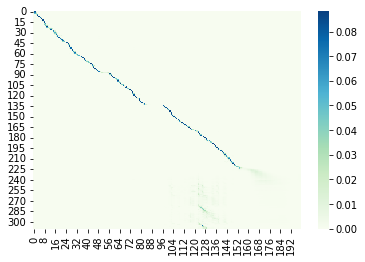


Epoch: 2/100


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 2/100: 
 Train Loss 0.0196	 Learning Rate 0.0000
Val Dist 9.8919


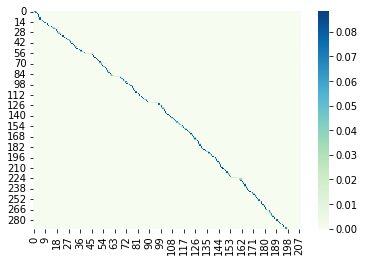


Epoch: 3/100


Train:   0%|          | 0/446 [00:00<?, ?it/s]

Val:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 3/100: 
 Train Loss 0.0223	 Learning Rate 0.0000
Val Dist 9.9530


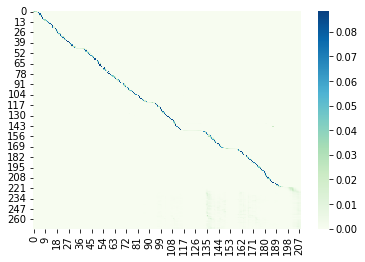


Epoch: 4/100


Train:   0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
best_lev_dist = 10
tf_rate = 0.4

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    curr_lr = float(optimizer.param_groups[0]['lr'])

    # Call train and validate 

    train_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf_rate)

    valid_dist = validate(model, val_loader)

    # Print your metrics

    print("\nEpoch {}/{}: \n Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_loss,
        curr_lr))
    
    print("Val Dist {:.04f}".format(valid_dist))

    # Plot Attention 
    plot_attention(attention_plot)

    # Log metrics to Wandb
    wandb.log({"train_loss":train_loss, 'validation_dist': valid_dist, "learning_Rate": curr_lr})

    # Optional: Scheduler Step / Teacher Force Schedule Step

    scheduler.step(valid_dist)

    if valid_dist <= 30 and valid_dist > 19:
      tf_rate = 0.95

    elif valid_dist <= 19 and valid_dist > 15:
      tf_rate = 0.75

    elif valid_dist <= 15 and valid_dist > 12:
      tf_rate = 0.65

    elif valid_dist <= 12 and valid_dist > 10:
      tf_rate = 0.55

    elif valid_dist <= 10 and valid_dist > 9.8:
      tf_rate = 0.5

    elif valid_dist <= 9.8 and valid_dist > 9.7:
      tf_rate = 0.48

    elif valid_dist <= 9.7 and valid_dist > 9.6:
      tf_rate = 0.47

    elif valid_dist <= 9.6 and valid_dist > 9.5:
      tf_rate = 0.46

    elif valid_dist <= 9.5 and valid_dist > 9.3:
      tf_rate = 0.45

    elif valid_dist <= 9.3 and valid_dist > 9.1:
      tf_rate = 0.43

    elif valid_dist <= 9.1 and valid_dist > 9:
      tf_rate = 0.41

    elif valid_dist <= 9:
      tf_rate = 0.39


    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './checkpoint.pth')
        torch.save(model,'best.pth')
      
        wandb.save('checkpoint.pth')
run.finish()

# Testing

In [ ]:
torch.save(model,'final_9.pth')

In [ ]:
validate(model1, val_loader)

Val:   0%|          | 0/43 [00:00<?, ?it/s]

9.891908914728681

In [ ]:
# Optional: Load your best model Checkpoint here

best_dist = torch.load('medium_checkpoint.pth')['val_dist']
print(best_dist)

12.299597537878787


In [ ]:
model1 = torch.load('/content/best.pth')

In [ ]:
# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle

def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")

    running_lev_dist = 0.0
    out = []

    for i, (x, lx) in enumerate(dataloader):

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None, tf_rate = 1)

        # Greedy Decoding
        greedy_predictions   =  predictions.argmax(dim=-1).detach().cpu() # TODO: How do you get the most likely character from each distribution in the batch?

        batch_size, seq_len = greedy_predictions.shape
        preds = []
        for batch_idx in range(batch_size): 
          pred_sliced = indices_to_chars(greedy_predictions[batch_idx], VOCAB)
          pred_string = ''.join(pred_sliced)
          preds.append(pred_string)
        

        # # Calculate Levenshtein Distance
        # running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        # batch_bar.set_postfix(
        #     dist="{:.04f}".format(running_lev_dist/(i+1)))
        # batch_bar.update()

        out.extend(preds)

        del x, lx,
        torch.cuda.empty_cache()

    batch_bar.close()
    # running_lev_dist /= len(dataloader)

    return out#, running_loss, running_perplexity, 

In [ ]:
# torch.cuda.empty_cache()
predictions = test(model1, test_loader)

with open("submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "I made it!"

Test:   0%|          | 0/41 [00:00<?, ?it/s]

100% 289k/289k [00:00<00:00, 1.44MB/s]
Successfully submitted to Attention-Based Speech Recognition